In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 14.9 MB/s eta 0:00:00


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import contractions

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Loading and Displaying Data**

In [ ]:
datasets, ds_info = tfds.load('huggingface:banking77', split=['train', 'test'], with_info=True, as_supervised=False)


/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:160: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/banking77/0.0.0.incomplete0WXD37/banking77-train.tfrecord*...:   0%|      …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/banking77/0.0.0.incomplete0WXD37/banking77-test.tfrecord*...:   0%|       …

Dataset banking77 downloaded and prepared to /root/tensorflow_datasets/banking77/0.0.0. Subsequent calls will reuse this data.


In [ ]:
# Unpack the datasets
dataset_train, dataset_test = datasets

# Extract the label names using the metadata
label_names = ds_info.features['label'].names

In [ ]:
for example in dataset_train.take(5):
    print(example)


{'label': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'text': <tf.Tensor: shape=(), dtype=string, numpy=b'I am still waiting on my card?'>}
{'label': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'text': <tf.Tensor: shape=(), dtype=string, numpy=b"What can I do if my card still hasn't arrived after 2 weeks?">}
{'label': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'text': <tf.Tensor: shape=(), dtype=string, numpy=b'I have been waiting over a week. Is the card still coming?'>}
{'label': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'text': <tf.Tensor: shape=(), dtype=string, numpy=b'Can I track my card while it is in the process of delivery?'>}
{'label': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'text': <tf.Tensor: shape=(), dtype=string, numpy=b'How do I know if I will get my card, or if it is lost?'>}


In [ ]:
for example in dataset_train.take(5):
    text = example['text'].numpy().decode('utf-8')
    label = int(example['label'].numpy())
    category = label_names[label]
    print(f'Text: {text}, Label: {label}, Category: {category}')


Text: I am still waiting on my card?, Label: 11, Category: card_arrival
Text: What can I do if my card still hasn't arrived after 2 weeks?, Label: 11, Category: card_arrival
Text: I have been waiting over a week. Is the card still coming?, Label: 11, Category: card_arrival
Text: Can I track my card while it is in the process of delivery?, Label: 11, Category: card_arrival
Text: How do I know if I will get my card, or if it is lost?, Label: 11, Category: card_arrival


In [ ]:
for example in dataset_test.take(5):
    text = example['text'].numpy().decode('utf-8')
    label = int(example['label'].numpy())
    category = label_names[label]
    print(f'Text: {text}, Label: {label}, Category: {category}')

Text: How do I locate my card?, Label: 11, Category: card_arrival
Text: I still have not received my new card, I ordered over a week ago., Label: 11, Category: card_arrival
Text: I ordered a card but it has not arrived. Help please!, Label: 11, Category: card_arrival
Text: Is there a way to know when my card will arrive?, Label: 11, Category: card_arrival
Text: My card has not arrived yet., Label: 11, Category: card_arrival


# **Exploratory Data Analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Collect all labels from the dataset
labels = [int(example['label'].numpy()) for example in dataset_train]

# Count the occurrences of each label
label_counts = np.bincount(labels)
label_names = ds_info.features['label'].names

# Create a DataFrame with label numbers, names, and counts
label_data = {'Label Number': range(len(label_counts)),
              'Label Name': label_names,
              'Number of Examples': label_counts}

df = pd.DataFrame(label_data)

# Sort by 'Number of Examples' in descending order
df_sorted = df.sort_values('Number of Examples', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(df_sorted)



    Label Number                                        Label Name  \
0             15                          card_payment_fee_charged   
1             28               direct_debit_payment_not_recognised   
2              6  balance_not_updated_after_cheque_or_cash_deposit   
3             75                     wrong_amount_of_cash_received   
4             19                            cash_withdrawal_charge   
..           ...                                               ...   
72            41                               lost_or_stolen_card   
73            18                                    card_swallowed   
74            10                                   card_acceptance   
75            72                          virtual_card_not_working   
76            23                           contactless_not_working   

    Number of Examples  
0                  187  
1                  182  
2                  181  
3                  180  
4                  177  
..       

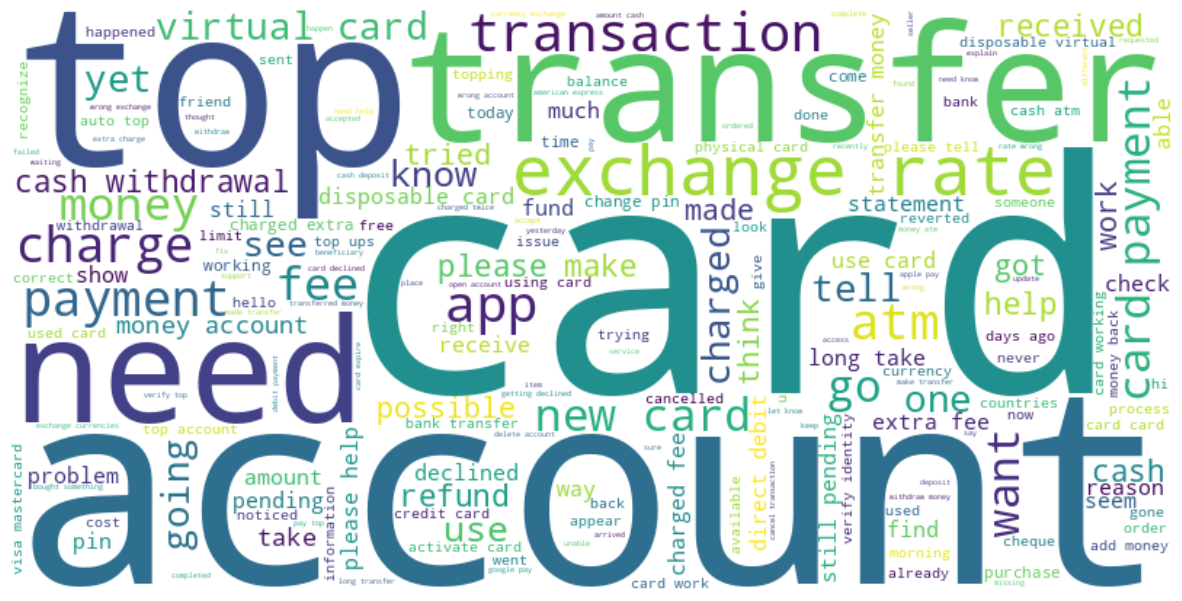

In [ ]:

from wordcloud import WordCloud
# Extract texts from the dataset and remove stop words
stop_words = set(stopwords.words('english'))
texts = [' '.join(word for word in example['text'].numpy().decode('utf-8').lower().split() if word not in stop_words)
         for example in dataset_train]

# Join all texts to create a combined string
combined_texts = ' '.join(texts)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_texts)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()



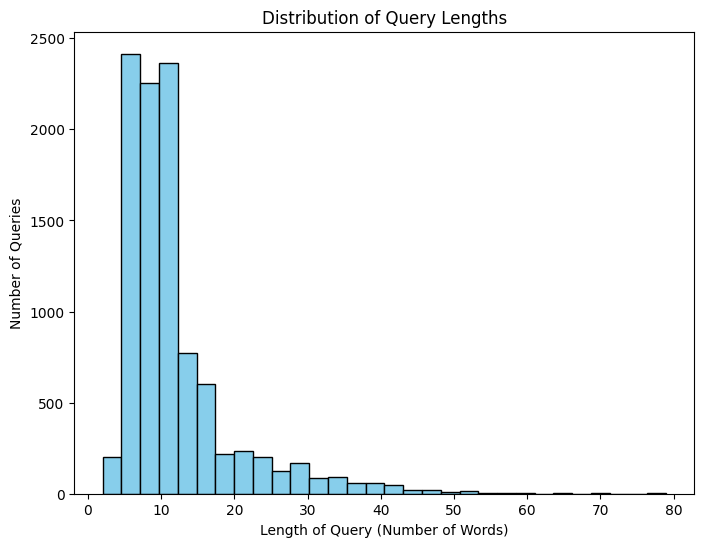

In [ ]:
# Query Length Analysis
text_lengths = [len(example['text'].numpy().decode('utf-8').split()) for example in dataset_train]

plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Query Lengths')
plt.xlabel('Length of Query (Number of Words)')
plt.ylabel('Number of Queries')
plt.show()


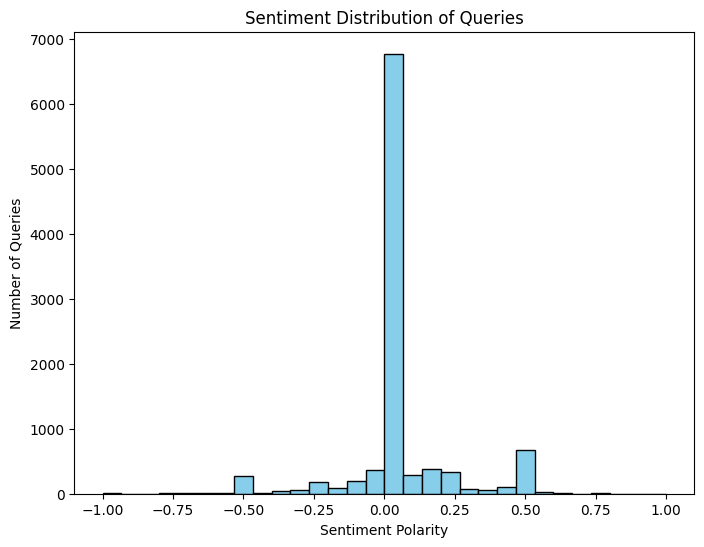

In [ ]:
from textblob import TextBlob

# Sentiment analysis on the texts
sentiments = [TextBlob(example['text'].numpy().decode('utf-8')).sentiment.polarity for example in dataset_train]

plt.figure(figsize=(8, 6))
plt.hist(sentiments, bins=30, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution of Queries')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Queries')
plt.show()


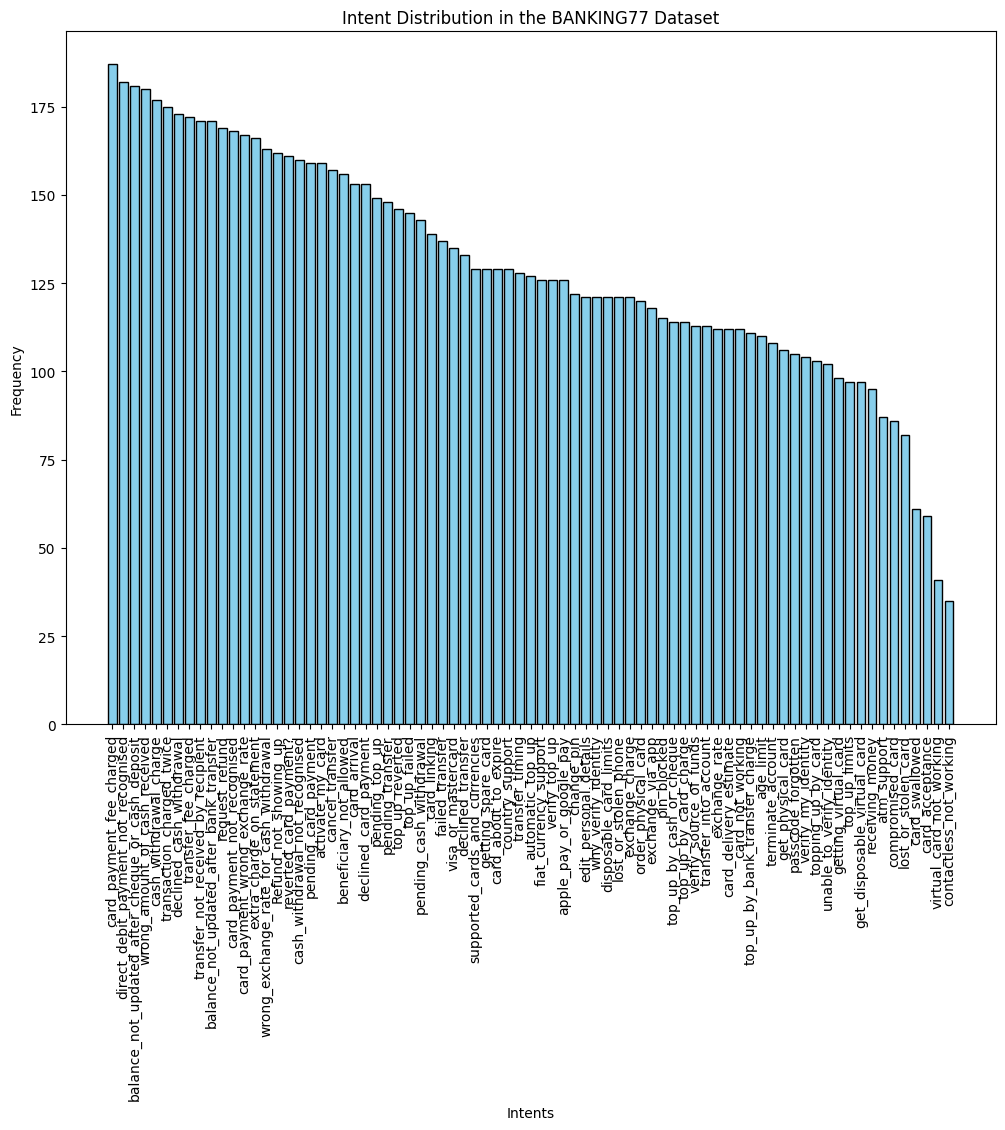

In [ ]:
# Extract intent labels from the dataset
intent_labels = [int(example['label'].numpy()) for example in dataset_train]

from collections import Counter
import matplotlib.pyplot as plt

# Count frequencies of each label
intent_freq = Counter(intent_labels)

# Get label names using dataset metadata
label_names = ds_info.features['label'].names

# Map label indices to label names
labeled_intents = [label_names[label] for label in intent_labels]

# Count frequencies of each named intent
named_intent_freq = Counter(labeled_intents)

# Extracting data for plotting
intents, intent_counts = zip(*named_intent_freq.most_common())

# Plotting the distribution of intents
plt.figure(figsize=(12, 9))
plt.bar(intents, intent_counts, color='skyblue', edgecolor='black')
plt.title('Intent Distribution in the BANKING77 Dataset')
plt.xticks(rotation=90)
plt.xlabel('Intents')
plt.ylabel('Frequency')
plt.show()

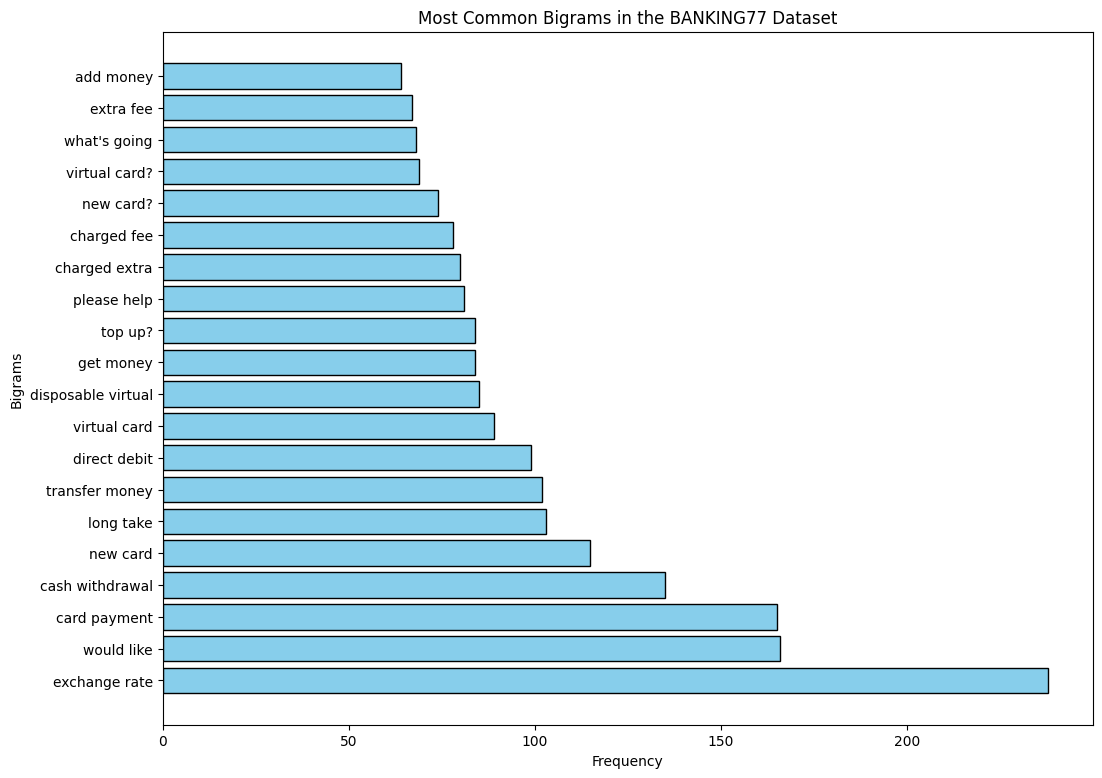

In [ ]:
from nltk import ngrams

def extract_ngrams(data, num):
    n_grams = ngrams(data, num)
    return [' '.join(grams) for grams in n_grams]

# Extract bigrams from texts
bigrams = Counter()
for example in dataset_train:
    text = example['text'].numpy().decode('utf-8').lower().split()
    filtered_text = [word for word in text if word not in stop_words]
    bigrams.update(extract_ngrams(filtered_text, 2))

most_common_bigrams = bigrams.most_common(20)
bigram_words, bigram_counts = zip(*most_common_bigrams)

plt.figure(figsize=(12, 9))
plt.barh(bigram_words, bigram_counts, color='skyblue', edgecolor='black')
plt.title('Most Common Bigrams in the BANKING77 Dataset')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()


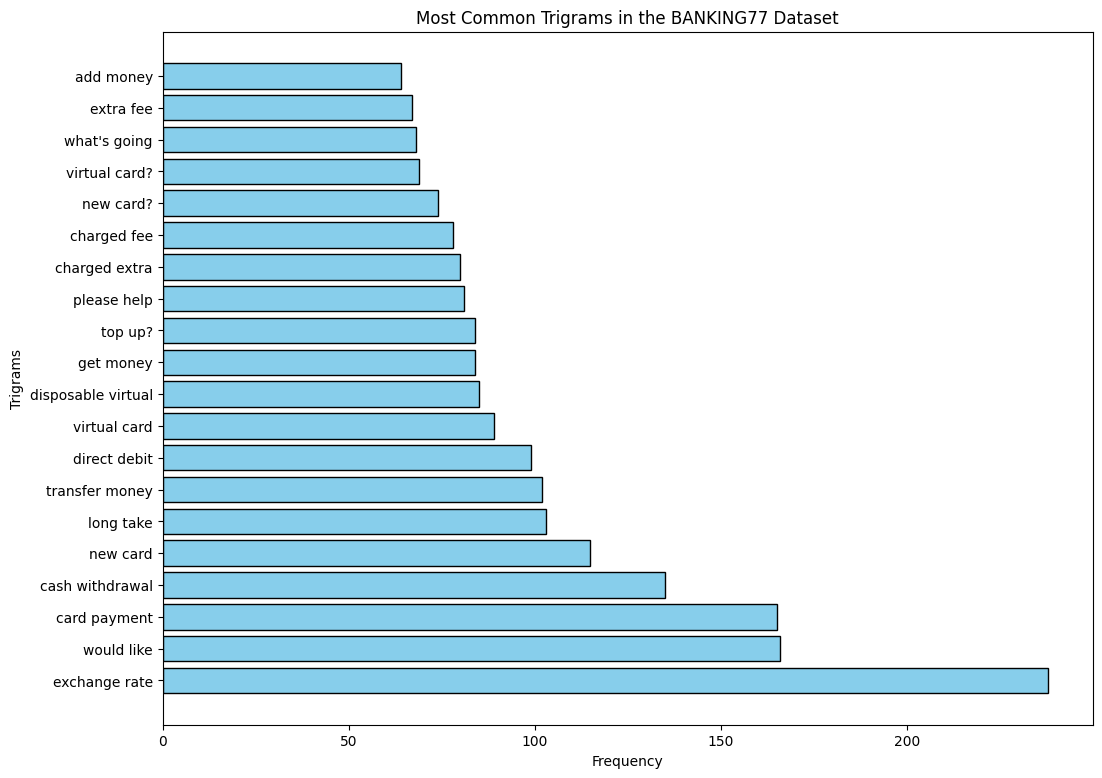

In [ ]:


def extract_ngrams(data, num):
    n_grams = ngrams(data, num)
    return [' '.join(grams) for grams in n_grams]

# Extract bigrams from texts
trigrams = Counter()
for example in dataset_train:
    text = example['text'].numpy().decode('utf-8').lower().split()
    filtered_text = [word for word in text if word not in stop_words]
    trigrams.update(extract_ngrams(filtered_text, 3))

most_common_trigrams = trigrams.most_common(20)
trigram_words, trigram_counts = zip(*most_common_trigrams)

plt.figure(figsize=(12, 9))
plt.barh(bigram_words, bigram_counts, color='skyblue', edgecolor='black')
plt.title('Most Common Trigrams in the BANKING77 Dataset')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.show()

In [ ]:
# Clear session
tf.keras.backend.clear_session()

# **Data Preprocessing**

In [ ]:
def load_and_shuffle_data(shuffle_train=False):
  dataset_train, dataset_test = tfds.load('huggingface:banking77', split=['train', 'test'])
  if shuffle_train:
      dataset_train = dataset_train.shuffle(buffer_size=10000, seed=42)
  train_data = list(dataset_train)
  test_data = list(dataset_test)
  sentences_train = [example['text'].numpy().decode('utf-8') for example in train_data]
  sentences_test = [example['text'].numpy().decode('utf-8') for example in test_data]
  labels_train = [example['label'].numpy() for example in train_data]
  labels_test = [example['label'].numpy() for example in test_data]
  return sentences_train, sentences_test, labels_train, labels_test

In [ ]:
def preprocess_sentences_withcontractions(sentences):
    stop_words = set(stopwords.words('english'))  # Set of English stop words
    punctuation_table = str.maketrans('', '', string.punctuation)  # Mapping table to remove punctuation
    lemmatizer = WordNetLemmatizer()  # NLTK Word lemmatizer

    processed_sentences = []
    for sentence in sentences:
        sentence = contractions.fix(sentence)
        # Create space around punctuation and remove double spaces
        sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)

        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Convert each word to lowercase, remove stopwords and punctuation
        words = [word.lower() for word in words ]

        # Remove non-alphanumeric characters and empty strings
        words = [re.sub(r'\W+', '', word) for word in words if word.isalnum()]

        # Lemmatize each word
        #words = [lemmatizer.lemmatize(word) for word in words]

        # Append the list of cleaned words to the processed_sentences list
        processed_sentences.append(words)

    return processed_sentences

In [ ]:
def preprocess_sentences_withoutpunctuations_lemmatized(sentences):
    stop_words = set(stopwords.words('english'))  # Set of English stop words
    punctuation_table = str.maketrans('', '', string.punctuation)  # Mapping table to remove punctuation
    lemmatizer = WordNetLemmatizer()  # NLTK Word lemmatizer

    processed_sentences = []
    for sentence in sentences:
        # Create space around punctuation and remove double spaces
        sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)

        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Convert each word to lowercase, remove stopwords and punctuation
        words = [word.lower() for word in words if word not in stop_words and word not in string.punctuation]

        # Remove non-alphanumeric characters and empty strings
        words = [re.sub(r'\W+', '', word) for word in words if word.isalnum()]

        # Lemmatize each word
        words = [lemmatizer.lemmatize(word) for word in words]

        # Append the list of cleaned words to the processed_sentences list
        processed_sentences.append(words)

    return processed_sentences

In [ ]:
def preprocess_sentences_withpunctuations_lemmatized(sentences):
    stop_words = set(stopwords.words('english'))  # Set of English stop words
    punctuation_table = str.maketrans('', '', string.punctuation)  # Mapping table to remove punctuation
    lemmatizer = WordNetLemmatizer()  # NLTK Word lemmatizer

    processed_sentences = []
    for sentence in sentences:
        # Create space around punctuation and remove double spaces
        sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)

        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Convert each word to lowercase, remove stopwords
        words = [word.lower() for word in words]

        # Remove non-alphanumeric characters and empty strings
        words = [re.sub(r'\W+', '', word) for word in words if word.isalnum()]

        # Lemmatize each word
        words = [lemmatizer.lemmatize(word) for word in words]

        # Append the list of cleaned words to the processed_sentences list
        processed_sentences.append(words)

    return processed_sentences

In [ ]:
def preprocess_sentences_withoutpunctuations_notlemmatized(sentences):
    stop_words = set(stopwords.words('english'))  # Set of English stop words
    punctuation_table = str.maketrans('', '', string.punctuation)  # Mapping table to remove punctuation
    lemmatizer = WordNetLemmatizer()  # NLTK Word lemmatizer

    processed_sentences = []
    for sentence in sentences:
        # Create space around punctuation and remove double spaces
        sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)

        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Convert each word to lowercase, remove stopwords and punctuation
        words = [word.lower() for word in words if word not in stop_words and word not in string.punctuation]

        # Remove non-alphanumeric characters and empty strings
        words = [re.sub(r'\W+', '', word) for word in words if word.isalnum()]

        # Lemmatize each word
        #words = [lemmatizer.lemmatize(word) for word in words]

        # Append the list of cleaned words to the processed_sentences list
        processed_sentences.append(words)

    return processed_sentences

In [ ]:
def preprocess_sentences_withpunctuations_notlemmatized(sentences):
    stop_words = set(stopwords.words('english'))  # Set of English stop words
    punctuation_table = str.maketrans('', '', string.punctuation)  # Mapping table to remove punctuation
    lemmatizer = WordNetLemmatizer()  # NLTK Word lemmatizer

    processed_sentences = []
    for sentence in sentences:
        # Create space around punctuation and remove double spaces
        sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)

        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Convert each word to lowercase, remove stopwords
        words = [word.lower() for word in words]

        # Remove non-alphanumeric characters and empty strings
        words = [re.sub(r'\W+', '', word) for word in words if word.isalnum()]

        # Lemmatize each word
        #words = [lemmatizer.lemmatize(word) for word in words]

        # Append the list of cleaned words to the processed_sentences list
        processed_sentences.append(words)

    return processed_sentences

In [ ]:
def create_word_index_and_train_word2vec(sentences, word_embedding_dim):
    word2vec_model = Word2Vec(sentences, vector_size=word_embedding_dim, window=10, min_count=1, workers=4)
    word2vec_model.build_vocab([["<UNK>"]], update=True)
    word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
    word_index['<UNK>'] = 0  # Assign index 0 to <UNK>
    return word_index, word2vec_model

def convert_words_to_ids(sentences, word_index):
    return [[word_index.get(word, word_index['<UNK>']) for word in sentence] for sentence in sentences]

def pad_sequences_to_max_length(sequences, max_length=None):
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    return pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

def create_embedding_matrix(word_index, word2vec_model, embedding_dim):
    max_features = len(word_index) + 1  # <UNK> uses 0 index
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model.wv and i > 0:  # Ensure i > 0 to skip <UNK>
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

In [ ]:
def create_word_index_and_train_word2vec_handlingoov(sentences, word_embedding_dim, negative_samples=20, initialize_unk_zero=False):
    sentences = [['<UNK>']] + sentences
    word2vec_model = Word2Vec(sentences, vector_size=word_embedding_dim, window=200, min_count=0, workers=4, negative=negative_samples)
    word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
    word_index['<UNK>'] = 0 if initialize_unk_zero else word2vec_model.wv.key_to_index['<UNK>']
    return word_index, word2vec_model

def convert_words_to_ids(sentences, word_index):
    return [[word_index.get(word, word_index['<UNK>']) for word in sentence] for sentence in sentences]

def pad_sequences_to_max_length(sequences, max_length=None):
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    return pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

def create_embedding_matrix_handlingoov(word_index, word2vec_model, embedding_dim):
    max_index = max(word_index.values())
    embedding_matrix = np.zeros((max_index+1, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

# **LSTM model without punctuations and stopwords - Lemmatized**

Epoch 1/30
313/313 [==============================] - 39s 97ms/step - loss: 4.0606 - accuracy: 0.0398 - val_loss: 3.5471 - val_accuracy: 0.0922
Epoch 2/30
  1/313 [..............................] - ETA: 37s - loss: 3.6581 - accuracy: 0.0625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 26s 84ms/step - loss: 3.2476 - accuracy: 0.1178 - val_loss: 2.9102 - val_accuracy: 0.1994
Epoch 3/30
313/313 [==============================] - 28s 90ms/step - loss: 2.8010 - accuracy: 0.1862 - val_loss: 2.4607 - val_accuracy: 0.3065
Epoch 4/30
313/313 [==============================] - 26s 83ms/step - loss: 2.4722 - accuracy: 0.2488 - val_loss: 2.1558 - val_accuracy: 0.3909
Epoch 5/30
313/313 [==============================] - 26s 83ms/step - loss: 2.1999 - accuracy: 0.3090 - val_loss: 1.8717 - val_accuracy: 0.4763
Epoch 6/30
313/313 [==============================] - 26s 83ms/step - loss: 1.9791 - accuracy: 0.3609 - val_loss: 1.7349 - val_accuracy: 0.5107
Epoch 7/30
313/313 [==============================] - 26s 83ms/step - loss: 1.7939 - accuracy: 0.4168 - val_loss: 1.5267 - val_accuracy: 0.5705
Epoch 8/30
313/313 [==============================] - 26s 83ms/step - loss: 1.6545 - accuracy: 0.4605 - val_loss: 1.4348 - val_accuracy: 0.5981
Epo

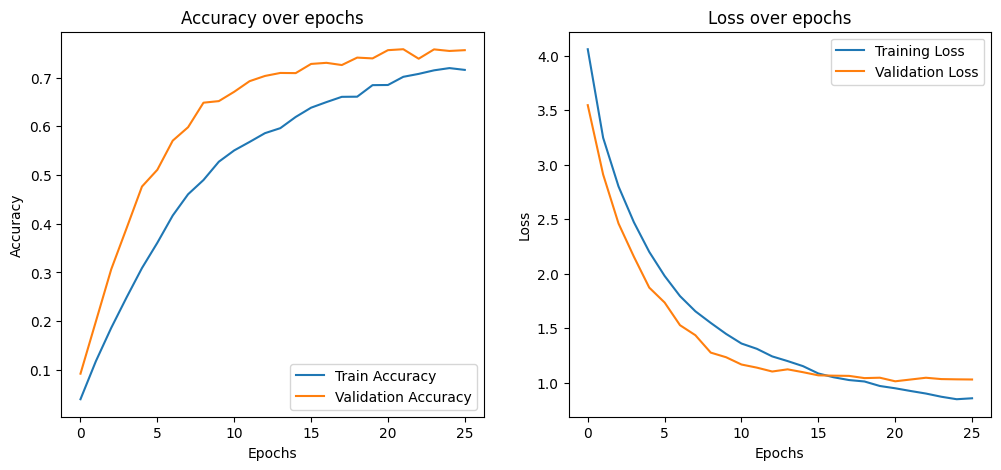

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withoutpunctuations_lemmatized(sentences_train)
tokenized_sentences_test = preprocess_sentences_withoutpunctuations_lemmatized(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec(tokenized_sentences_train, 100)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, 100)

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], mask_zero=True),
    LSTM(64, return_sequences=True),  # More units and returning sequences for stacking
    Dropout(0.3),
    LSTM(32),  # Additional LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **LSTM model with punctuations and stopwords - Lemmatized**

Epoch 1/30
313/313 [==============================] - 51s 133ms/step - loss: 3.9839 - accuracy: 0.0538 - val_loss: 3.5321 - val_accuracy: 0.1136
Epoch 2/30
313/313 [==============================] - 39s 124ms/step - loss: 3.2625 - accuracy: 0.1265 - val_loss: 2.8906 - val_accuracy: 0.2185
Epoch 3/30
313/313 [==============================] - 39s 123ms/step - loss: 2.8055 - accuracy: 0.2009 - val_loss: 2.4310 - val_accuracy: 0.3282
Epoch 4/30
313/313 [==============================] - 39s 124ms/step - loss: 2.4431 - accuracy: 0.2611 - val_loss: 2.0624 - val_accuracy: 0.4156
Epoch 5/30
313/313 [==============================] - 39s 125ms/step - loss: 2.1311 - accuracy: 0.3259 - val_loss: 1.7807 - val_accuracy: 0.4857
Epoch 6/30
313/313 [==============================] - 39s 124ms/step - loss: 1.9019 - accuracy: 0.3873 - val_loss: 1.5797 - val_accuracy: 0.5471
Epoch 7/30
313/313 [==============================] - 39s 125ms/step - loss: 1.7275 - accuracy: 0.4397 - val_loss: 1.4321 - val_ac

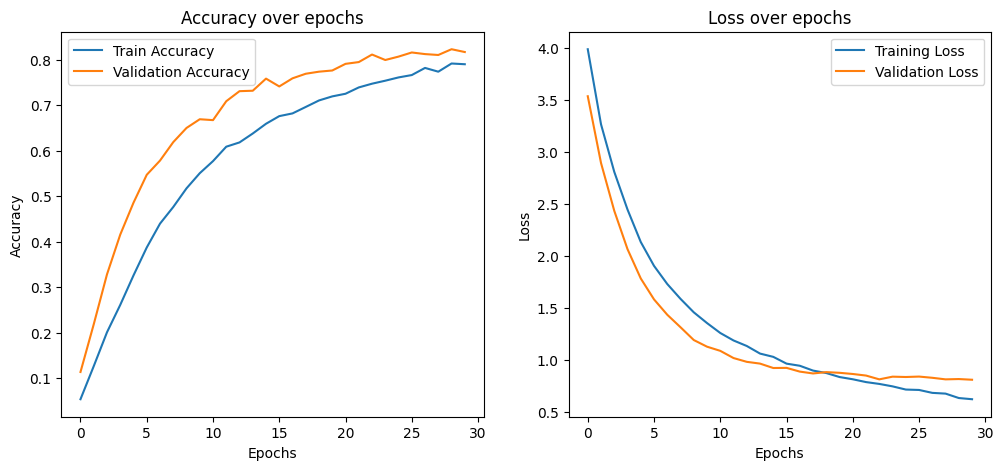

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withpunctuations_lemmatized(sentences_train)
tokenized_sentences_test = preprocess_sentences_withpunctuations_lemmatized(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec(tokenized_sentences_train, 100)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, 100)

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], mask_zero=True),
    LSTM(64, return_sequences=True),  # More units and returning sequences for stacking
    Dropout(0.3),
    LSTM(32),  # Additional LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model2.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **LSTM model without punctuations and stopwords - NotLemmatized**

Epoch 1/30
313/313 [==============================] - 39s 98ms/step - loss: 4.1320 - accuracy: 0.0300 - val_loss: 3.7544 - val_accuracy: 0.0698
Epoch 2/30
313/313 [==============================] - 27s 87ms/step - loss: 3.3948 - accuracy: 0.0965 - val_loss: 3.0041 - val_accuracy: 0.1838
Epoch 3/30
313/313 [==============================] - 26s 84ms/step - loss: 2.8922 - accuracy: 0.1560 - val_loss: 2.5440 - val_accuracy: 0.2805
Epoch 4/30
313/313 [==============================] - 27s 87ms/step - loss: 2.5425 - accuracy: 0.2319 - val_loss: 2.2027 - val_accuracy: 0.3795
Epoch 5/30
313/313 [==============================] - 26s 84ms/step - loss: 2.2406 - accuracy: 0.2986 - val_loss: 1.9114 - val_accuracy: 0.4565
Epoch 6/30
313/313 [==============================] - 28s 88ms/step - loss: 1.9830 - accuracy: 0.3637 - val_loss: 1.6652 - val_accuracy: 0.5461
Epoch 7/30
313/313 [==============================] - 26s 85ms/step - loss: 1.7764 - accuracy: 0.4255 - val_loss: 1.5069 - val_accuracy:

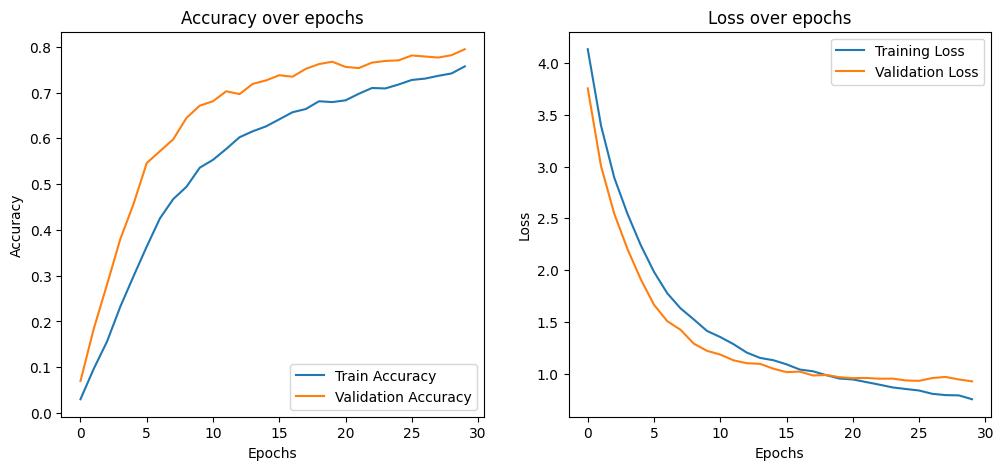

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withoutpunctuations_notlemmatized(sentences_train)
tokenized_sentences_test = preprocess_sentences_withoutpunctuations_notlemmatized(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec(tokenized_sentences_train, 100)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, 100)

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], mask_zero=True),
    LSTM(64, return_sequences=True),  # More units and returning sequences for stacking
    Dropout(0.3),
    LSTM(32),  # Additional LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model3.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **LSTM model with punctuations and stopwords - NonLemmatized**

Epoch 1/30
313/313 [==============================] - 52s 141ms/step - loss: 3.9667 - accuracy: 0.0447 - val_loss: 3.5458 - val_accuracy: 0.1000
Epoch 2/30
313/313 [==============================] - 39s 124ms/step - loss: 3.2610 - accuracy: 0.1281 - val_loss: 2.9183 - val_accuracy: 0.2136
Epoch 3/30
313/313 [==============================] - 39s 124ms/step - loss: 2.7614 - accuracy: 0.2056 - val_loss: 2.3638 - val_accuracy: 0.3581
Epoch 4/30
313/313 [==============================] - 39s 124ms/step - loss: 2.3789 - accuracy: 0.2874 - val_loss: 2.0088 - val_accuracy: 0.4403
Epoch 5/30
313/313 [==============================] - 39s 124ms/step - loss: 2.0476 - accuracy: 0.3675 - val_loss: 1.6698 - val_accuracy: 0.5331
Epoch 6/30
313/313 [==============================] - 39s 123ms/step - loss: 1.8263 - accuracy: 0.4203 - val_loss: 1.4872 - val_accuracy: 0.5812
Epoch 7/30
313/313 [==============================] - 39s 123ms/step - loss: 1.6234 - accuracy: 0.4818 - val_loss: 1.3057 - val_ac

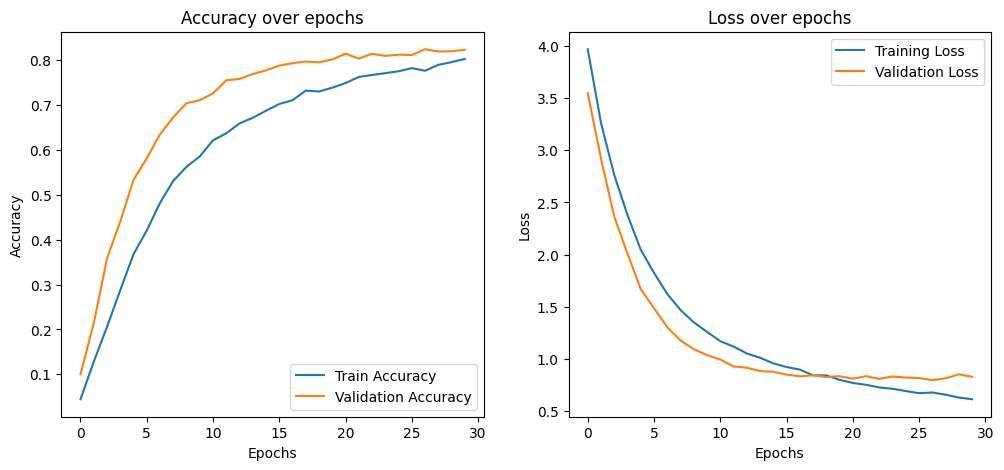

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withpunctuations_notlemmatized(sentences_train)
tokenized_sentences_test = preprocess_sentences_withpunctuations_notlemmatized(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec(tokenized_sentences_train, 100)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, 100)

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], mask_zero=True),
    LSTM(64, return_sequences=True),  # More units and returning sequences for stacking
    Dropout(0.3),
    LSTM(32),  # Additional LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model4.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
best_model = tf.keras.models.load_model('best_model.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)

# Assuming ds_info is available and has a feature descriptor for labels
label_names = ds_info.features['label'].names
# Predicting the probabilities
predictions = best_model.predict(padded_test)

# Converting probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Extract true classes from one-hot encoded test labels
true_classes = np.argmax(labels_test_one_hot, axis=1)

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=label_names)

# Print the classification report
print(report)

97/97 [==============================] - 5s 24ms/step
                                                  precision    recall  f1-score   support

                                activate_my_card       0.95      0.95      0.95        40
                                       age_limit       0.93      0.97      0.95        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       0.97      0.95      0.96        40
                                automatic_top_up       0.80      0.80      0.80        40
         balance_not_updated_after_bank_transfer       0.57      0.70      0.63        40
balance_not_updated_after_cheque_or_cash_deposit       0.83      0.72      0.77        40
                         beneficiary_not_allowed       0.70      0.78      0.74        40
                                 cancel_transfer       0.89      0.85      0.87        40
                            card_about_to_exp

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


97/97 [==============================] - 6s 60ms/step


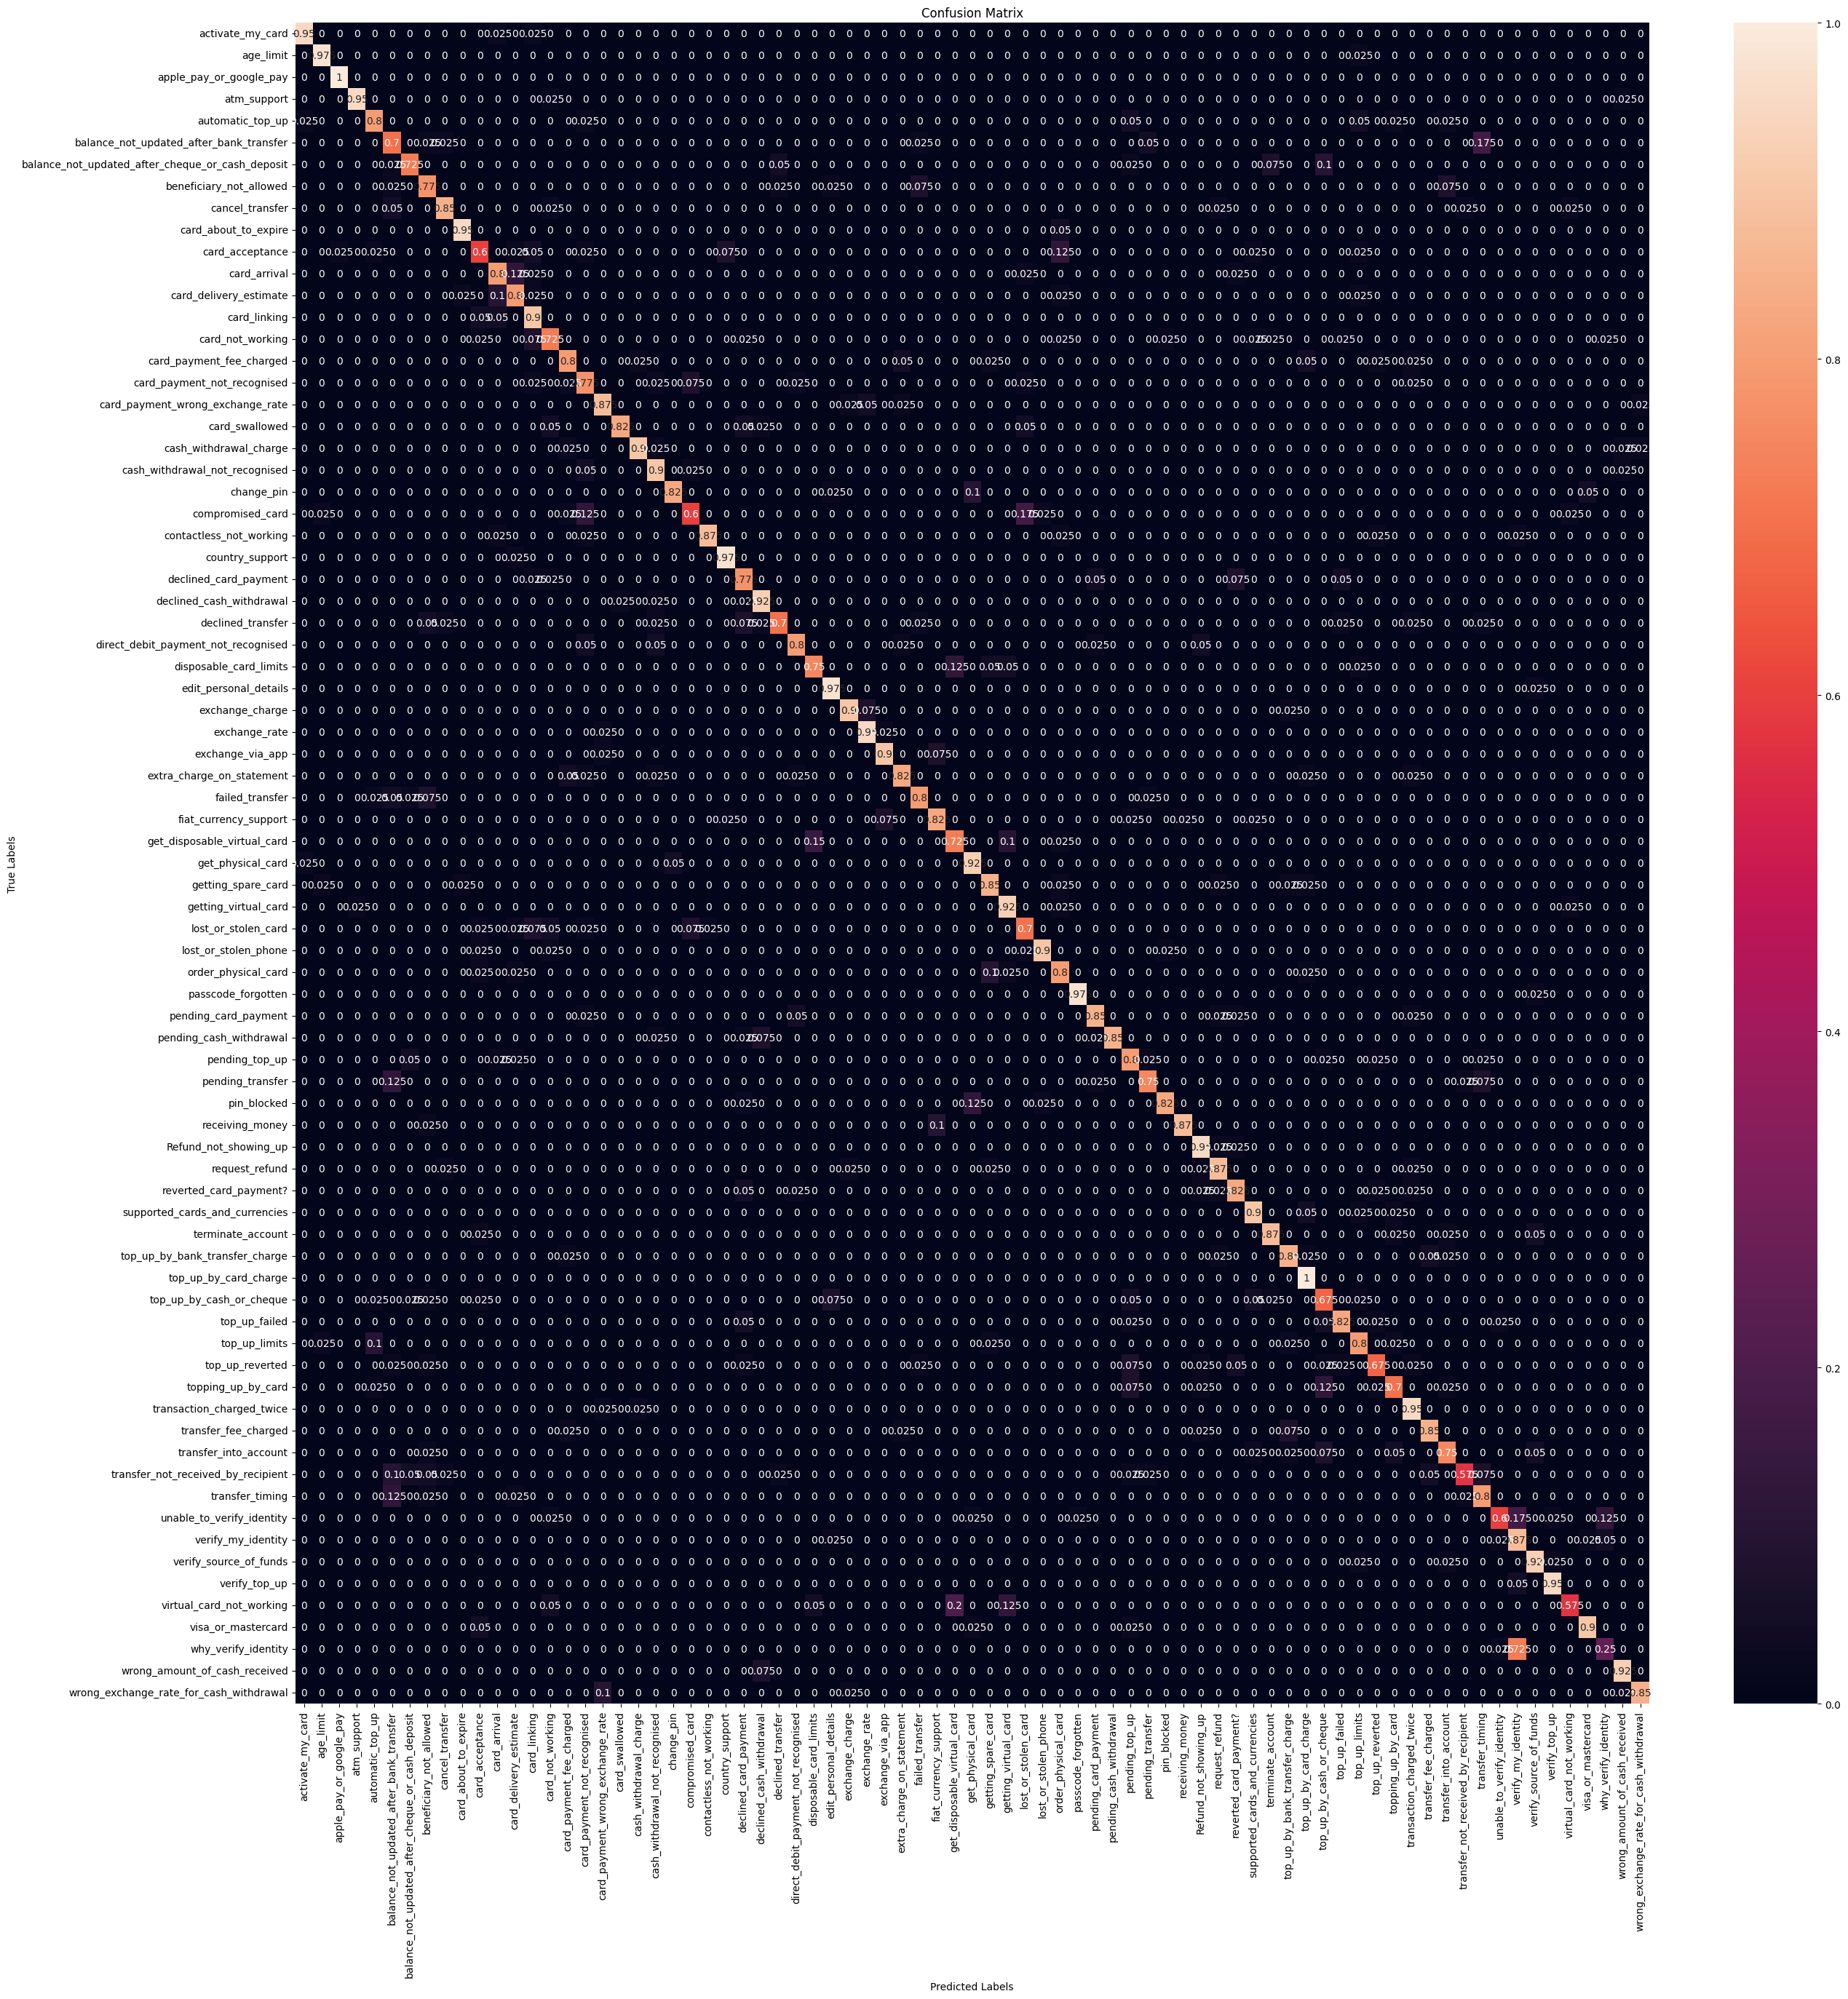

In [ ]:
# Predicting the probabilities
predictions = best_model.predict(padded_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_one_hot, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Optional: Normalize the confusion matrix by the number of samples in each class
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(30, 30))  # You can adjust the size to fit your needs
sns.heatmap(cm_normalized, annot=True, fmt='g',  xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)  # Keeping the labels horizontal
plt.show()


# **Hyperparameter Tuning**

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withpunctuations_notlemmatized(sentences_train)
tokenized_sentences_test = preprocess_sentences_withpunctuations_notlemmatized(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec(tokenized_sentences_train, 100)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, 100)

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

def build_model(hp):
    model = tf.keras.Sequential([
        Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], mask_zero=True),
        LSTM(hp.Int('units_lstm1', min_value=32, max_value=128, step=32), return_sequences=True),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        LSTM(hp.Int('units_lstm2', min_value=32, max_value=128, step=32)),
        Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(hp.Int('units_dense', min_value=32, max_value=128, step=32), activation='relu'),
        Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(num_classes, activation='softmax')
    ])

    # Use a learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float('initial_lr', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set a small number for demonstration
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start the search process
tuner.search(padded_train, labels_train_one_hot, epochs=30, validation_data=(padded_test, labels_test_one_hot), callbacks=[early_stopping])


Trial 10 Complete [00h 13m 24s]
val_accuracy: 0.8123376369476318

Best val_accuracy So Far: 0.8451298475265503
Total elapsed time: 03h 16m 27s


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from keras_tuner import RandomSearch

# Assuming 'tuner' is your Keras Tuner object after running the tuning
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Best Model Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Best Model Test Loss: {test_loss:.4f}")

# Optionally, you can print the best hyperparameters
print("Best hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

97/97 [==============================] - 11s 69ms/step - loss: 0.6739 - accuracy: 0.8451
Best Model Test Accuracy: 84.51%
Best Model Test Loss: 0.6739
Best hyperparameters:
units_lstm1: 128
dropout_1: 0.30000000000000004
units_lstm2: 64
dropout_2: 0.30000000000000004
units_dense: 128
dropout_3: 0.30000000000000004
initial_lr: 0.003982162357170975


In [ ]:
tuner.results_summary()


Results summary
Results in my_dir/lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_lstm1: 128
dropout_1: 0.30000000000000004
units_lstm2: 64
dropout_2: 0.30000000000000004
units_dense: 128
dropout_3: 0.30000000000000004
initial_lr: 0.003982162357170975
Score: 0.8451298475265503

Trial 02 summary
Hyperparameters:
units_lstm1: 96
dropout_1: 0.2
units_lstm2: 128
dropout_2: 0.2
units_dense: 96
dropout_3: 0.30000000000000004
initial_lr: 0.00694090003577775
Score: 0.8431817889213562

Trial 07 summary
Hyperparameters:
units_lstm1: 64
dropout_1: 0.30000000000000004
units_lstm2: 32
dropout_2: 0.30000000000000004
units_dense: 96
dropout_3: 0.30000000000000004
initial_lr: 0.0009756992661327715
Score: 0.8415584564208984

Trial 08 summary
Hyperparameters:
units_lstm1: 96
dropout_1: 0.30000000000000004
units_lstm2: 96
dropout_2: 0.30000000000000004
units_dense: 32
dropout_3: 0.30000000000000004
initial_lr: 0.00133694361035081

# **Model with updated Hyperparameters**

Epoch 1/30
313/313 [==============================] - 89s 255ms/step - loss: 3.2525 - accuracy: 0.1385 - val_loss: 2.0727 - val_accuracy: 0.3435
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 74s 238ms/step - loss: 1.6825 - accuracy: 0.4616 - val_loss: 1.1793 - val_accuracy: 0.6312
Epoch 3/30
313/313 [==============================] - 74s 236ms/step - loss: 1.0957 - accuracy: 0.6493 - val_loss: 0.8884 - val_accuracy: 0.7286
Epoch 4/30
313/313 [==============================] - 93s 299ms/step - loss: 0.8313 - accuracy: 0.7441 - val_loss: 0.7826 - val_accuracy: 0.7789
Epoch 5/30
313/313 [==============================] - 78s 248ms/step - loss: 0.6674 - accuracy: 0.7973 - val_loss: 0.7136 - val_accuracy: 0.8114
Epoch 6/30
313/313 [==============================] - 79s 254ms/step - loss: 0.5416 - accuracy: 0.8354 - val_loss: 0.6881 - val_accuracy: 0.8221
Epoch 7/30
313/313 [==============================] - 74s 238ms/step - loss: 0.4822 - accuracy: 0.8496 - val_loss: 0.6513 - val_accuracy: 0.8338
Epoch 8/30
313/313 [==============================] - 82s 263ms/step - loss: 0.4281 - accuracy: 0.8695 - val_loss: 0.6493 - val_accuracy: 0.8

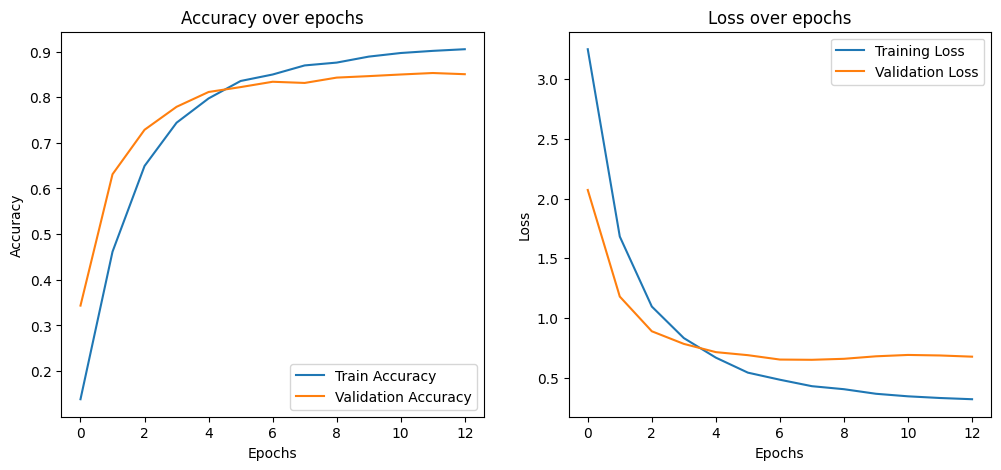

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withpunctuations_notlemmatized(sentences_train)
tokenized_sentences_test = preprocess_sentences_withpunctuations_notlemmatized(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec(tokenized_sentences_train, 100)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, 100)

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], mask_zero=True),
    LSTM(128, return_sequences=True),  # More units and returning sequences for stacking
    Dropout(0.3),
    LSTM(64),  # Additional LSTM layer
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.004
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model4.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model4.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/30
313/313 [==============================] - 106s 311ms/step - loss: 3.1470 - accuracy: 0.1588 - val_loss: 2.0082 - val_accuracy: 0.4023
Epoch 2/30
313/313 [==============================] - 97s 310ms/step - loss: 1.6447 - accuracy: 0.4783 - val_loss: 1.1331 - val_accuracy: 0.6490
Epoch 3/30
313/313 [==============================] - 95s 304ms/step - loss: 1.0944 - accuracy: 0.6598 - val_loss: 0.8717 - val_accuracy: 0.7406
Epoch 4/30
313/313 [==============================] - 96s 306ms/step - loss: 0.8534 - accuracy: 0.7357 - val_loss: 0.7641 - val_accuracy: 0.7883
Epoch 5/30
313/313 [==============================] - 92s 295ms/step - loss: 0.7151 - accuracy: 0.7756 - val_loss: 0.7120 - val_accuracy: 0.8081
Epoch 6/30
313/313 [==============================] - 93s 296ms/step - loss: 0.6115 - accuracy: 0.8183 - val_loss: 0.7044 - val_accuracy: 0.8253
Epoch 7/30
313/313 [==============================] - 92s 295ms/step - loss: 0.5527 - accuracy: 0.8319 - val_loss: 0.7083 - val_a

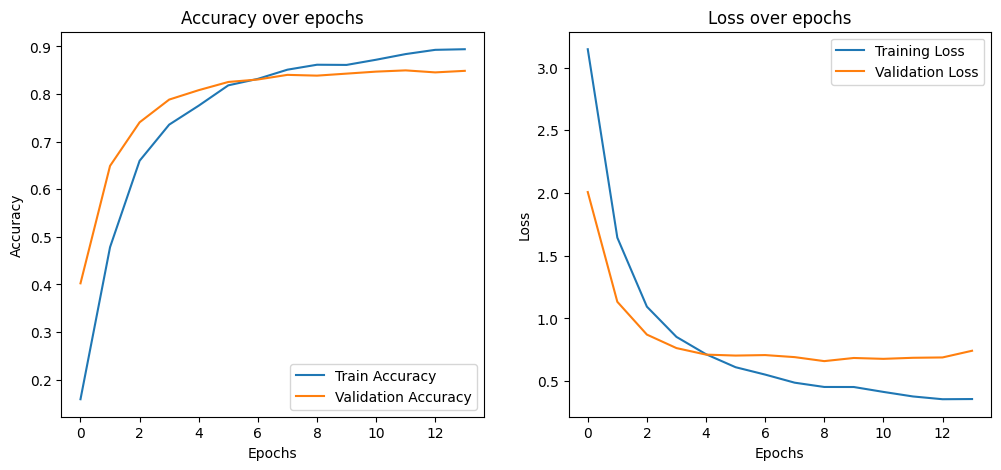

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withcontractions(sentences_train)
tokenized_sentences_test = preprocess_sentences_withcontractions(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec_handlingoov(tokenized_sentences_train, 250)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix_handlingoov(word_index, word2vec_model, 250)
max_index=max(word_index.values())

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim= max_index + 1, output_dim=250, weights=[embedding_matrix], mask_zero=True),
    LSTM(128, return_sequences=True),  # More units and returning sequences for stacking
    Dropout(0.3),
    LSTM(64),  # Additional LSTM layer
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.004
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model5.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model5.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/30
313/313 [==============================] - 207s 607ms/step - loss: 3.0021 - accuracy: 0.1936 - val_loss: 1.6335 - val_accuracy: 0.5052
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 219s 699ms/step - loss: 1.4060 - accuracy: 0.5663 - val_loss: 1.0467 - val_accuracy: 0.6860
Epoch 3/30
313/313 [==============================] - 193s 616ms/step - loss: 0.9017 - accuracy: 0.7213 - val_loss: 0.8280 - val_accuracy: 0.7747
Epoch 4/30
313/313 [==============================] - 189s 606ms/step - loss: 0.6772 - accuracy: 0.7933 - val_loss: 0.7710 - val_accuracy: 0.7893
Epoch 5/30
313/313 [==============================] - 181s 578ms/step - loss: 0.5901 - accuracy: 0.8248 - val_loss: 0.7433 - val_accuracy: 0.8162
Epoch 6/30
313/313 [==============================] - 189s 604ms/step - loss: 0.4998 - accuracy: 0.8500 - val_loss: 0.7364 - val_accuracy: 0.8136
Epoch 7/30
313/313 [==============================] - 188s 602ms/step - loss: 0.4345 - accuracy: 0.8694 - val_loss: 0.7376 - val_accuracy: 0.8247
Epoch 8/30
313/313 [==============================] - 188s 600ms/step - loss: 0.3943 - accuracy: 0.8820 - val_loss: 0.7559 - val_accura

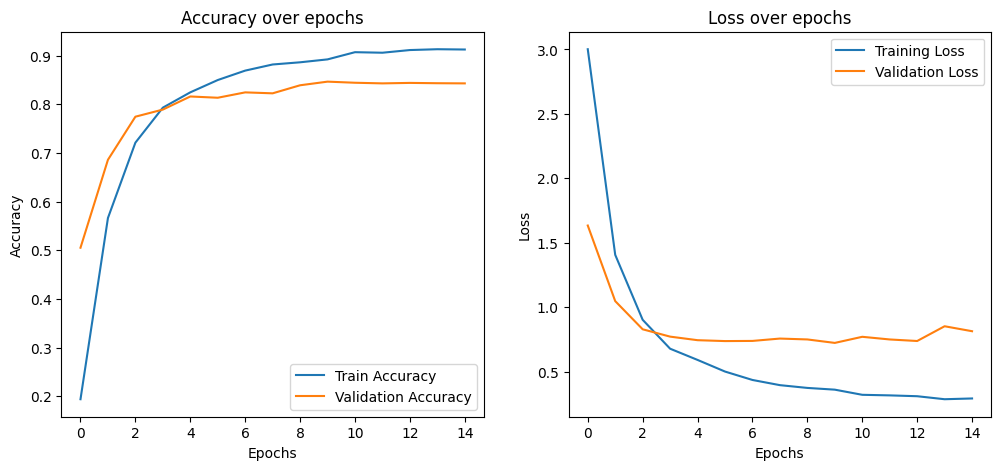

In [ ]:
# Load and preprocess data
sentences_train, sentences_test, labels_train, labels_test = load_and_shuffle_data(shuffle_train=True)
tokenized_sentences_train = preprocess_sentences_withcontractions(sentences_train)
tokenized_sentences_test = preprocess_sentences_withcontractions(sentences_test)
word_index, word2vec_model = create_word_index_and_train_word2vec_handlingoov(tokenized_sentences_train, 250)

# Convert sentences to IDs and pad sequences
id_sequences_train = convert_words_to_ids(tokenized_sentences_train, word_index)
id_sequences_test = convert_words_to_ids(tokenized_sentences_test, word_index)
padded_train = pad_sequences_to_max_length(id_sequences_train)
padded_test = pad_sequences_to_max_length(id_sequences_test)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix_handlingoov(word_index, word2vec_model, 250)
max_index=max(word_index.values())

# One-hot encoding of labels
num_classes = 77
labels_train_one_hot = to_categorical(labels_train, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test, num_classes=num_classes)

# Model definition with advanced layer configuration
model = tf.keras.Sequential([
    Embedding(input_dim= max_index + 1, output_dim=250, weights=[embedding_matrix], mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),  # More units and returning sequences for stacking
    Dropout(0.3),
    Bidirectional(LSTM(64)),  # Additional LSTM layer
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name="AdvancedLSTMModel")

# Setting up a variable learning rate
initial_learning_rate = 0.004
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('best_model7.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and checkpointing
history = model.fit(padded_train, labels_train_one_hot, epochs=30,
                    validation_data=(padded_test, labels_test_one_hot),
                    callbacks=[early_stopping, checkpoint])

# Load the best model and evaluate its performance
best_model = tf.keras.models.load_model('best_model7.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
best_model = tf.keras.models.load_model('best_model7.h5')
test_loss, test_accuracy = best_model.evaluate(padded_test, labels_test_one_hot)

# Assuming ds_info is available and has a feature descriptor for labels
label_names = ds_info.features['label'].names
# Predicting the probabilities
predictions = best_model.predict(padded_test)

# Converting probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Extract true classes from one-hot encoded test labels
true_classes = np.argmax(labels_test_one_hot, axis=1)

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=label_names)

# Print the classification report
print(report)

97/97 [==============================] - 18s 133ms/step
                                                  precision    recall  f1-score   support

                                activate_my_card       0.93      0.95      0.94        40
                                       age_limit       0.95      0.93      0.94        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       0.91      0.97      0.94        40
                                automatic_top_up       0.92      0.82      0.87        40
         balance_not_updated_after_bank_transfer       0.67      0.82      0.74        40
balance_not_updated_after_cheque_or_cash_deposit       0.94      0.85      0.89        40
                         beneficiary_not_allowed       0.86      0.75      0.80        40
                                 cancel_transfer       0.89      0.85      0.87        40
                            card_about_to_e

In [ ]:
text1 = ["Someone grabbed my card and ran away,now I dont have access to the card"]
predictclass(text1)

1/1 [==============================] - 0s 184ms/step


'lost_or_stolen_card'

In [ ]:
def predictclass(text):

  new_sequences = convert_words_to_ids(preprocess_sentences_withcontractions(texts), word_index)
  new_padded = pad_sequences(new_sequences, maxlen=142, padding='post')
  predicted_class = np.argmax(best_model.predict(new_padded))
  return (label_names[predicted_class])
